In [242]:
%pip install anthropic

In [243]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import lightgbm as lgb
from anthropic import Anthropic
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.sparse import hstack
import joblib
from anthropic import Anthropic


In [321]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("thedevastator/sms-spam-collection-a-more-diverse-dataset")

# print("Path to dataset files:", path)

# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("jackksoncsie/spam-email-dataset")

# print("Path to dataset files:", path)

import kagglehub

# Download latest version
path = kagglehub.dataset_download("meruvulikith/190k-spam-ham-email-dataset-for-classification")

print("Path to dataset files:", path)

100%|██████████| 107M/107M [00:01<00:00, 94.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meruvulikith/190k-spam-ham-email-dataset-for-classification/versions/1


In [322]:
# !ls /root/.cache/kagglehub/datasets/thedevastator/sms-spam-collection-a-more-diverse-dataset/versions/2
!ls /root/.cache/kagglehub/datasets/meruvulikith/190k-spam-ham-email-dataset-for-classification/versions/1


spam_Emails_data.csv


In [323]:
!mkdir -p datasets

In [324]:
!cp -r /root/.cache/kagglehub/datasets/meruvulikith/190k-spam-ham-email-dataset-for-classification/versions/1/spam_Emails_data.csv datasets/emails.csv
!ls datasets

emails.csv  sms-spam.csv


In [325]:
df = pd.read_csv("datasets/emails.csv")
df.head()

,label,text
0,Spam,viiiiiiagraaaa\nonly for the ones that want to...
1,Ham,got ice thought look az original message ice o...
2,Spam,yo ur wom an ne eds an escapenumber in ch ma n...
3,Spam,start increasing your odds of success & live s...
4,Ham,author jra date escapenumber escapenumber esca...


In [327]:
df["label"] = df["label"].replace({"Spam": 1, "Ham": 0})
df.head()

<ipython-input-327-237a6c874a50>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["label"] = df["label"].replace({"Spam": 1, "Ham": 0})


,label,text
0,1,viiiiiiagraaaa\nonly for the ones that want to...
1,0,got ice thought look az original message ice o...
2,1,yo ur wom an ne eds an escapenumber in ch ma n...
3,1,start increasing your odds of success & live s...
4,0,author jra date escapenumber escapenumber esca...


In [328]:
df.shape

(193852, 2)

In [329]:
df.isna().sum()

,0
label,0
text,2


In [332]:
df = df.dropna()
df.isna().sum()

,0
label,0
text,0


In [333]:
df.duplicated().sum()

0

In [297]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [334]:
df.shape

(193850, 2)

In [336]:
  mask = df["label"] == 1
  num_spam = len(df[mask])
  mask = df["label"] == 0
  num_safe = len(df[mask])
  print(f"Number of Spam Emails: {num_spam:,}")
  print(f"Number of Spam Emails: {num_safe:,}")

Number of Spam Emails: 91,691
Number of Spam Emails: 102,159


In [340]:
X = df["text"]
y = df["label"]
print(X[:3])
print(y[:3])

0    viiiiiiagraaaa\nonly for the ones that want to...
1    got ice thought look az original message ice o...
2    yo ur wom an ne eds an escapenumber in ch ma n...
Name: text, dtype: object
0    1
1    0
2    1
Name: label, dtype: int64


In [341]:
import re
from bs4 import BeautifulSoup
def clean_email(text):
    # Remove HTML/CSS
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Remove email addresses
    text = re.sub(r"\S+@\S+", "", text)

    # Remove special characters (keep letters, numbers, and basic punctuation)
    text = re.sub(r"[^a-zA-Z0-9.!?]+", " ", text)

    # Lowercase
    text = text.lower()

    return text

In [342]:
def extract_features(text):
    features = {}

    # Number of links
    features["num_links"] = len(re.findall(r"http\S+", text))

    # Number of obfuscated words (e.g., "p@ypal")
    features["num_obfuscated"] = len(re.findall(r"\w+[@\$]\w+", text))

    # Urgency keywords
    urgency_words = ["urgent", "immediately", "verify", "password"]
    features["urgency_score"] = sum(text.count(word) for word in urgency_words)

    return features

In [343]:
model = joblib.load("malicious_email_classifier.pkl")
model

LGBMClassifier(class_weight='balanced', min_child_samples=50, n_jobs=2,
               num_leaves=127, random_state=42, verbose=-1)

In [344]:
tfidf_vectorizer = joblib.load("tfidf_vectorizer.pkl")
tfidf_vectorizer

TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

In [345]:
def get_lgbm_predictions(model, email_text):
    start_time = time.time()

    # Extract manual features before cleaning
    email_manual_features = extract_features(email_text)
    email_manual_features_array = np.array([[
        email_manual_features['num_links'],
        email_manual_features['num_obfuscated'],
        email_manual_features['urgency_score']
    ]])

    # Clean email for TF-IDF
    email_text_clean = clean_email(email_text)
    email_tfidf = tfidf_vectorizer.transform([email_text_clean])

    email_features_combined = hstack([email_tfidf, email_manual_features_array])

    y_pred = model.predict(email_features_combined)
    end_time = time.time()
    probability = model.predict_proba(email_features_combined)[0][1]
    result = "malicious" if y_pred[0] == 1 else "safe"
    latency = end_time - start_time

    return y_pred, probability, result, latency

In [346]:
text = """Dear，

Maximus has new advanced industrail  and Military SSD

2.5'' SATAIII -40C-+85C SSD up to 16TB

2.5'' U2  -40C-+85C SSD up to 16TB

CFX  -40C-+85C SSD up to 2TB

M.2 2280 SATAIII -40C-+85C SSD up to 8TB

M.2 PCIE GEN4X4 -40C-+85C SSD up to 8TB

DDR4 3200 -40C-+85C up to 32GB

Maximus also the rich SSD production line with 2.5'' SATAIII/mSATAIII/M.2 SATAIII/M.2 PCIE/Halfslim SATAIII/Cfast SATAIII/CF/1.8'' micro SATAIII/SD/microSD/2.5''PATA/DDR3/DDR4/DDR3L/mimi mSATAIII

supporting SLC/MLC/3D TLC with 0-70C and -40C-+85C from 1GB-8TB

We use all Toshiba Kioxia IC with 5 years warranty



do you have some new SSD and DDR needs ?

Maximus has 7 years warranty



Best regards

Kevinvon

2025-02-21 00:13:00

--------------------------------------------------------

Kevinvon

Email:Kevinvon@maximustek.net

COO  Maximus Technology（HongKong) Co., Ltd

+8613829942555

www.maximustek.com
"""

features_dict = extract_features(text)

y_pred, probability, latency, features = get_lgbm_predictions(model, text)
y_pred, probability, latency, features

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


(array([1]), 0.5073950827954495, 'malicious', 0.005223512649536133)

In [347]:
from ast import Raise
from logging import raiseExceptions
from google.colab import userdata

try:
    api_key = userdata.get('CLAUDE_API_KEY')
    if not api_key:
        raise ValueError("CLAUDE_API_KEY not found in userdata.")
    client = Anthropic(api_key=api_key)
except Exception as e:
    print(f"Failed to initialize Anthropic client: {e}")
    client = None

In [383]:
def get_llm_verification(email_text, lgbm_prediction, lgbm_confidence, features):
    """
    Ask Claude to verify the LightGBM prediction
    Returns: The LLM's classification (0 for safe, 1 for malicious)
    """
    start_time = time.time()

    feature_text = ", ".join([f"{k}: {v}" for k, v in features.items()])

    try:
        message = client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=150,
            temperature=0.0,  # Keep deterministic for experiment consistency
            system="""You are a cybersecurity expert verifying email classifications.
            Your task is to review the LightGBM model's classification and either agree or disagree.
            Be extremely concise. Respond ONLY with "SAFE" or "MALICIOUS" - nothing else.""",
            messages=[
                {
                    "role": "user",
                    "content": f"""
                    Email Content: {email_text[:3000]}
                    LightGBM Classification: {'Malicious' if lgbm_prediction == 1 else 'Safe'}
                    Confidence: {lgbm_confidence:.2%}
                    Features: {feature_text}

                    Based solely on your analysis of this email, would you classify it as SAFE or MALICIOUS?
                    Respond with just one word: SAFE or MALICIOUS.
                    """
                }
            ]
        )

        llm_output = message.content[0].text.strip().upper()

        # Convert LLM response to binary classification
        print("  " + llm_output)
        if "MALICIOUS" in llm_output:
            llm_classification = 1
        elif "SAFE" in llm_output:
            llm_classification = 0
        else:
            # Default to LightGBM if LLM doesn't provide a clear answer
            print("\n\n\nIGNORED\n\n\n")
            llm_classification = lgbm_prediction

    except Exception as e:
        print(f"LLM verification error: {e}")
        # Default to LightGBM prediction if LLM fails
        llm_classification = lgbm_prediction

    end_time = time.time()
    latency = end_time - start_time

    return llm_classification, latency

In [384]:
features_dict = {
    'num_links': 1,
    'num_obfuscated': 0,
    'urgency_score': 0
}

result = get_llm_verification(text, y_pred, probability, features_dict)
result

  SAFE


(0, 0.96706223487854)

In [375]:
probability

0.5073950827954495

In [385]:
def run_experiment(X_test, y_test, lgbm_model, sample_size=100, random_seed=42):
    """
    Run both models on a sample of test data and compare results
    """
    import numpy as np
    from scipy.sparse import hstack
    from tqdm import tqdm
    import pandas as pd

    np.random.seed(random_seed)

    # Handle case where X_test is a Series
    if isinstance(X_test, pd.Series):
        series_name = X_test.name if X_test.name is not None else "text"
        X_test = pd.DataFrame({series_name: X_test})
        text_column = series_name
    else:
        # Determine text column name
        text_column = 'sms' if 'sms' in X_test.columns else 'email_text'

    # Fix: Sample from the actual index values instead of assuming sequential indices
    all_indices = X_test.index.tolist()
    sample_indices = np.random.choice(all_indices, size=min(sample_size, len(all_indices)), replace=False)
    X_sample = X_test.loc[sample_indices]

    # Make sure y_test is sampled using the same indices
    if hasattr(y_test, 'loc'):
        # If y_test is a pandas Series or DataFrame
        y_sample = y_test.loc[sample_indices]
    else:
        # If y_test is a numpy array - need to map indices to positions
        index_to_position = {idx: pos for pos, idx in enumerate(all_indices)}
        y_positions = [index_to_position[idx] for idx in sample_indices]
        y_sample = y_test[y_positions]

    # Get the raw text data
    texts = X_sample[text_column].values

    # Get LightGBM predictions - process each sample individually
    lgbm_predictions = []
    lgbm_raw_predictions = []
    lgbm_latencies = []

    for i, (idx, row) in enumerate(X_sample.iterrows()):
        y_pred, probability, result, latency = get_lgbm_predictions(lgbm_model, row[text_column])
        lgbm_predictions.append(1 if result == "malicious" else 0)
        lgbm_raw_predictions.append(probability)
        lgbm_latencies.append(latency)

    # Store results
    results = {
        'lgbm_predictions': np.array(lgbm_predictions),
        'combined_predictions': [],
        'lgbm_latency': np.mean(lgbm_latencies),  # Use mean latency
        'llm_latencies': [],
        'agreement_rate': 0,
        'true_labels': y_sample
    }

    # Extract features for each sample - if Series, create a simple feature dictionary
    for i, (index, row) in tqdm(enumerate(X_sample.iterrows()), total=len(X_sample)):
        # For Series converted to DataFrame, there might not be additional features
        if X_sample.shape[1] > 1:
            features = {col: row[col] for col in X_sample.columns if col != text_column}
        else:
            # If no other features are available, create a minimal feature set
            features = {"text_length": len(row[text_column])}

        # Get LLM verification
        llm_classification, llm_latency = get_llm_verification(
            row[text_column],  # Pass the text directly
            lgbm_predictions[i],  # Use the stored prediction
            lgbm_raw_predictions[i],  # Use the stored probability
            features
        )
        print(llm_classification)

        # Store results
        results['combined_predictions'].append(llm_classification)
        results['llm_latencies'].append(llm_latency)

    # Calculate metrics
    results['combined_predictions'] = np.array(results['combined_predictions'])
    results['llm_latencies'] = np.array(results['llm_latencies'])
    results['agreement_rate'] = np.mean(results['lgbm_predictions'] == results['combined_predictions'])

    # Calculate performance metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    # LightGBM metrics
    results['lgbm_accuracy'] = accuracy_score(y_sample, results['lgbm_predictions'])
    results['lgbm_precision'] = precision_score(y_sample, results['lgbm_predictions'], zero_division=0)
    results['lgbm_recall'] = recall_score(y_sample, results['lgbm_predictions'], zero_division=0)
    results['lgbm_f1'] = f1_score(y_sample, results['lgbm_predictions'], zero_division=0)

    # Combined model metrics
    results['combined_accuracy'] = accuracy_score(y_sample, results['combined_predictions'])
    results['combined_precision'] = precision_score(y_sample, results['combined_predictions'], zero_division=0)
    results['combined_recall'] = recall_score(y_sample, results['combined_predictions'], zero_division=0)
    results['combined_f1'] = f1_score(y_sample, results['combined_predictions'], zero_division=0)

    return results

In [386]:
X.head()

,text
0,viiiiiiagraaaa\nonly for the ones that want to...
1,got ice thought look az original message ice o...
2,yo ur wom an ne eds an escapenumber in ch ma n...
3,start increasing your odds of success & live s...
4,author jra date escapenumber escapenumber esca...


In [392]:
results = run_experiment(X, y, model, sample_size=500)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: U

  SAFE
0


  0%|          | 2/500 [00:00<03:45,  2.21it/s]

  SAFE
0


  1%|          | 3/500 [00:01<02:57,  2.81it/s]

  SAFE
0


  1%|          | 4/500 [00:01<02:44,  3.01it/s]

  MALICIOUS
1


  1%|          | 5/500 [00:01<02:46,  2.97it/s]

  SAFE
0


  1%|          | 6/500 [00:02<02:59,  2.76it/s]

  SAFE
0


  1%|▏         | 7/500 [00:02<03:02,  2.70it/s]

  MALICIOUS
1


  2%|▏         | 8/500 [00:02<02:59,  2.75it/s]

  MALICIOUS
1


  2%|▏         | 9/500 [00:03<02:37,  3.12it/s]

  MALICIOUS
1


  2%|▏         | 10/500 [00:03<02:25,  3.36it/s]

  SAFE
0


  2%|▏         | 11/500 [00:03<02:37,  3.10it/s]

  MALICIOUS
1


  2%|▏         | 12/500 [00:04<03:10,  2.56it/s]

  MALICIOUS
1


  3%|▎         | 13/500 [00:04<02:58,  2.73it/s]

  MALICIOUS
1


  3%|▎         | 14/500 [00:04<02:47,  2.90it/s]

  MALICIOUS
1


  3%|▎         | 16/500 [00:05<02:12,  3.65it/s]

  MALICIOUS
1
  MALICIOUS
1


  3%|▎         | 17/500 [00:05<02:31,  3.18it/s]

  SAFE
0


  4%|▎         | 18/500 [00:06<02:29,  3.22it/s]

  SAFE
0


  4%|▍         | 19/500 [00:06<02:30,  3.19it/s]

  MALICIOUS
1


  4%|▍         | 20/500 [00:06<02:17,  3.50it/s]

  SAFE
0


  4%|▍         | 21/500 [00:07<03:08,  2.54it/s]

  MALICIOUS
1


  4%|▍         | 22/500 [00:07<02:44,  2.90it/s]

  MALICIOUS
1


  5%|▍         | 23/500 [00:08<04:17,  1.85it/s]

  MALICIOUS
1


  5%|▍         | 24/500 [00:09<04:59,  1.59it/s]

  MALICIOUS
1


  5%|▌         | 25/500 [00:09<04:18,  1.84it/s]

  SAFE
0


  5%|▌         | 26/500 [00:10<04:02,  1.95it/s]

  MALICIOUS
1


  5%|▌         | 27/500 [00:10<03:37,  2.18it/s]

  MALICIOUS
1


  6%|▌         | 28/500 [00:11<04:38,  1.70it/s]

  SAFE
0
  MALICIOUS
1


  6%|▌         | 30/500 [00:11<03:24,  2.30it/s]

  SAFE
0


  6%|▌         | 31/500 [00:12<03:11,  2.45it/s]

  SAFE
0


  6%|▋         | 32/500 [00:12<03:14,  2.41it/s]

  SAFE
0


  7%|▋         | 33/500 [00:12<03:01,  2.57it/s]

  SAFE
0


  7%|▋         | 34/500 [00:13<03:14,  2.40it/s]

  SAFE
0


  7%|▋         | 35/500 [00:13<02:57,  2.62it/s]

  SAFE
0


  7%|▋         | 37/500 [00:14<02:33,  3.01it/s]

  MALICIOUS
1
  MALICIOUS
1


  8%|▊         | 38/500 [00:14<02:27,  3.14it/s]

  MALICIOUS
1


  8%|▊         | 39/500 [00:14<02:29,  3.09it/s]

  SAFE
0


  8%|▊         | 40/500 [00:15<02:22,  3.23it/s]

  SAFE
0


  8%|▊         | 41/500 [00:15<02:41,  2.85it/s]

  SAFE
0


  8%|▊         | 42/500 [00:16<02:50,  2.69it/s]

  SAFE
0


  9%|▊         | 43/500 [00:16<02:27,  3.10it/s]

  SAFE
0


  9%|▉         | 44/500 [00:16<02:33,  2.97it/s]

  MALICIOUS
1


  9%|▉         | 45/500 [00:16<02:21,  3.21it/s]

  MALICIOUS
1


  9%|▉         | 46/500 [00:17<02:34,  2.94it/s]

  SAFE
0


  9%|▉         | 47/500 [00:17<02:29,  3.03it/s]

  SAFE
0


 10%|▉         | 48/500 [00:17<02:22,  3.16it/s]

  MALICIOUS
1


 10%|█         | 50/500 [00:18<02:07,  3.52it/s]

  MALICIOUS
1
  MALICIOUS
1


 10%|█         | 51/500 [00:18<02:12,  3.40it/s]

  MALICIOUS
1


 10%|█         | 52/500 [00:19<02:29,  3.01it/s]

  SAFE
0


 11%|█         | 53/500 [00:19<02:19,  3.20it/s]

  MALICIOUS
1


 11%|█         | 54/500 [00:19<02:07,  3.50it/s]

  SAFE
0


 11%|█         | 56/500 [00:20<01:56,  3.80it/s]

  SAFE
0
  SAFE
0


 11%|█▏        | 57/500 [00:20<02:05,  3.54it/s]

  SAFE
0


 12%|█▏        | 58/500 [00:20<02:17,  3.21it/s]

  MALICIOUS
1


 12%|█▏        | 59/500 [00:21<02:15,  3.27it/s]

  SAFE
0


 12%|█▏        | 60/500 [00:21<02:27,  2.99it/s]

  SAFE
0


 12%|█▏        | 61/500 [00:22<02:46,  2.64it/s]

  MALICIOUS
1


 12%|█▏        | 62/500 [00:22<02:25,  3.01it/s]

  MALICIOUS
1


 13%|█▎        | 63/500 [00:22<02:30,  2.91it/s]

  MALICIOUS
1


 13%|█▎        | 64/500 [00:22<02:11,  3.31it/s]

  SAFE
0


 13%|█▎        | 65/500 [00:23<02:04,  3.50it/s]

  SAFE
0


 13%|█▎        | 66/500 [00:23<02:06,  3.44it/s]

  SAFE
0


 13%|█▎        | 67/500 [00:23<02:13,  3.25it/s]

  MALICIOUS
1


 14%|█▎        | 68/500 [00:24<02:12,  3.26it/s]

  SAFE
0


 14%|█▍        | 69/500 [00:24<02:10,  3.31it/s]

  MALICIOUS
1


 14%|█▍        | 70/500 [00:24<02:19,  3.08it/s]

  SAFE
0


 14%|█▍        | 71/500 [00:25<02:32,  2.81it/s]

  MALICIOUS
1


 14%|█▍        | 72/500 [00:25<02:30,  2.84it/s]

  MALICIOUS
1


 15%|█▍        | 73/500 [00:25<02:16,  3.14it/s]

  MALICIOUS
1


 15%|█▍        | 74/500 [00:26<03:26,  2.06it/s]

  SAFE
0


 15%|█▌        | 75/500 [00:27<03:11,  2.21it/s]

  MALICIOUS
1


 15%|█▌        | 76/500 [00:27<03:01,  2.33it/s]

  MALICIOUS
1


 16%|█▌        | 78/500 [00:27<02:21,  2.98it/s]

  SAFE
0
  MALICIOUS
1


 16%|█▌        | 79/500 [00:28<02:30,  2.79it/s]

  SAFE
0


 16%|█▌        | 80/500 [00:28<02:30,  2.79it/s]

  SAFE
0


 16%|█▌        | 81/500 [00:28<02:20,  2.99it/s]

  MALICIOUS
1


 16%|█▋        | 82/500 [00:29<02:19,  3.00it/s]

  MALICIOUS
1


 17%|█▋        | 83/500 [00:30<03:24,  2.03it/s]

  MALICIOUS
1


 17%|█▋        | 84/500 [00:30<03:16,  2.12it/s]

  SAFE
0


 17%|█▋        | 86/500 [00:31<02:28,  2.79it/s]

  SAFE
0
  MALICIOUS
1


 17%|█▋        | 87/500 [00:31<02:26,  2.82it/s]

  SAFE
0


 18%|█▊        | 88/500 [00:31<02:19,  2.95it/s]

  MALICIOUS
1


 18%|█▊        | 89/500 [00:32<02:12,  3.11it/s]

  SAFE
0


 18%|█▊        | 90/500 [00:32<02:24,  2.84it/s]

  MALICIOUS
1


 18%|█▊        | 91/500 [00:32<02:17,  2.98it/s]

  MALICIOUS
1


 18%|█▊        | 92/500 [00:33<02:20,  2.90it/s]

  SAFE
0


 19%|█▊        | 93/500 [00:33<02:12,  3.06it/s]

  MALICIOUS
1


 19%|█▉        | 94/500 [00:33<02:22,  2.85it/s]

  MALICIOUS
1


 19%|█▉        | 95/500 [00:34<02:07,  3.18it/s]

  SAFE
0


 19%|█▉        | 96/500 [00:34<02:27,  2.73it/s]

  MALICIOUS
1


 19%|█▉        | 97/500 [00:34<02:11,  3.07it/s]

  SAFE
0


 20%|█▉        | 98/500 [00:35<03:04,  2.18it/s]

  MALICIOUS
1


 20%|█▉        | 99/500 [00:35<02:53,  2.31it/s]

  SAFE
0


 20%|██        | 100/500 [00:36<02:44,  2.43it/s]

  MALICIOUS
1


 20%|██        | 102/500 [00:36<02:02,  3.25it/s]

  SAFE
0
  MALICIOUS
1


 21%|██        | 103/500 [00:37<02:06,  3.15it/s]

  MALICIOUS
1


 21%|██        | 104/500 [00:37<02:22,  2.78it/s]

  SAFE
0


 21%|██        | 105/500 [00:37<02:33,  2.58it/s]

  SAFE
0


 21%|██        | 106/500 [00:38<02:30,  2.62it/s]

  MALICIOUS
1


 21%|██▏       | 107/500 [00:38<02:13,  2.94it/s]

  SAFE
0


 22%|██▏       | 108/500 [00:38<01:59,  3.28it/s]

  MALICIOUS
1


 22%|██▏       | 109/500 [00:39<02:31,  2.58it/s]

  SAFE
0


 22%|██▏       | 110/500 [00:39<02:34,  2.53it/s]

  SAFE
0


 22%|██▏       | 111/500 [00:40<02:25,  2.68it/s]

  MALICIOUS
1


 22%|██▏       | 112/500 [00:40<02:26,  2.64it/s]

  SAFE
0


 23%|██▎       | 113/500 [00:40<02:14,  2.87it/s]

  MALICIOUS
1


 23%|██▎       | 114/500 [00:41<02:18,  2.78it/s]

  SAFE
0


 23%|██▎       | 115/500 [00:41<02:14,  2.87it/s]

  MALICIOUS
1


 23%|██▎       | 116/500 [00:41<02:20,  2.72it/s]

  SAFE
0


 23%|██▎       | 117/500 [00:42<02:20,  2.73it/s]

  SAFE
0


 24%|██▎       | 118/500 [00:42<02:13,  2.85it/s]

  SAFE
0


 24%|██▍       | 119/500 [00:43<03:12,  1.98it/s]

  SAFE
0


 24%|██▍       | 120/500 [00:43<02:53,  2.19it/s]

  MALICIOUS
1


 24%|██▍       | 121/500 [00:44<02:35,  2.43it/s]

  SAFE
0


 24%|██▍       | 122/500 [00:44<02:42,  2.33it/s]

  SAFE
0


 25%|██▍       | 123/500 [00:45<02:45,  2.28it/s]

  SAFE
0


 25%|██▍       | 124/500 [00:45<02:41,  2.33it/s]

  MALICIOUS
1


 25%|██▌       | 125/500 [00:45<02:52,  2.17it/s]

  SAFE
0


 25%|██▌       | 126/500 [00:46<02:52,  2.17it/s]

  MALICIOUS
1


 25%|██▌       | 127/500 [00:46<02:47,  2.22it/s]

  SAFE
0


 26%|██▌       | 128/500 [00:47<02:21,  2.63it/s]

  SAFE
0


 26%|██▌       | 129/500 [00:47<02:01,  3.04it/s]

  SAFE
0


 26%|██▌       | 130/500 [00:47<02:27,  2.51it/s]

  MALICIOUS
1


 26%|██▌       | 131/500 [00:48<02:21,  2.61it/s]

  MALICIOUS
1


 26%|██▋       | 132/500 [00:48<02:24,  2.54it/s]

  SAFE
0


 27%|██▋       | 134/500 [00:49<01:56,  3.13it/s]

  MALICIOUS
1
  SAFE
0


 27%|██▋       | 135/500 [00:49<02:58,  2.04it/s]

  MALICIOUS
1


 27%|██▋       | 136/500 [00:50<02:34,  2.35it/s]

  SAFE
0


 27%|██▋       | 137/500 [00:50<02:28,  2.44it/s]

  SAFE
0


 28%|██▊       | 138/500 [00:50<02:09,  2.79it/s]

  SAFE
0


 28%|██▊       | 139/500 [00:51<02:21,  2.55it/s]

  SAFE
0


 28%|██▊       | 140/500 [00:51<02:11,  2.73it/s]

  MALICIOUS
1


 28%|██▊       | 142/500 [00:52<01:50,  3.23it/s]

  MALICIOUS
1
  MALICIOUS
1


 29%|██▊       | 143/500 [00:52<01:41,  3.53it/s]

  SAFE
0


 29%|██▉       | 144/500 [00:52<01:42,  3.47it/s]

  MALICIOUS
1


 29%|██▉       | 145/500 [00:53<01:50,  3.22it/s]

  MALICIOUS
1


 29%|██▉       | 146/500 [00:53<01:49,  3.24it/s]

  MALICIOUS
1


 29%|██▉       | 147/500 [00:53<01:58,  2.99it/s]

  MALICIOUS
1


 30%|██▉       | 148/500 [00:54<02:02,  2.86it/s]

  SAFE
0


 30%|██▉       | 149/500 [00:54<02:07,  2.76it/s]

  MALICIOUS
1


 30%|███       | 150/500 [00:54<02:07,  2.75it/s]

  MALICIOUS
1


 30%|███       | 151/500 [00:55<02:05,  2.77it/s]

  SAFE
0


 30%|███       | 152/500 [00:55<02:34,  2.25it/s]

  MALICIOUS
1


 31%|███       | 153/500 [00:56<02:22,  2.44it/s]

  MALICIOUS
1


 31%|███       | 154/500 [00:56<02:14,  2.57it/s]

  MALICIOUS
1


 31%|███       | 155/500 [00:56<01:55,  2.99it/s]

  MALICIOUS
1


 31%|███       | 156/500 [00:57<01:56,  2.96it/s]

  MALICIOUS
1


 31%|███▏      | 157/500 [00:57<02:03,  2.77it/s]

  MALICIOUS
1


 32%|███▏      | 158/500 [00:57<02:06,  2.70it/s]

  MALICIOUS
1


 32%|███▏      | 159/500 [00:58<02:09,  2.64it/s]

  SAFE
0


 32%|███▏      | 160/500 [00:58<02:08,  2.65it/s]

  MALICIOUS
1


 32%|███▏      | 161/500 [00:58<01:57,  2.90it/s]

  MALICIOUS
1


 32%|███▏      | 162/500 [00:59<01:43,  3.27it/s]

  SAFE
0


 33%|███▎      | 163/500 [00:59<01:45,  3.18it/s]

  MALICIOUS
1


 33%|███▎      | 164/500 [00:59<01:35,  3.51it/s]

  MALICIOUS
1


 33%|███▎      | 165/500 [01:00<01:37,  3.42it/s]

  MALICIOUS
1


 33%|███▎      | 166/500 [01:00<01:29,  3.74it/s]

  MALICIOUS
1


 33%|███▎      | 167/500 [01:00<01:34,  3.53it/s]

  SAFE
0


 34%|███▎      | 168/500 [01:00<01:27,  3.82it/s]

  SAFE
0


 34%|███▍      | 169/500 [01:01<01:30,  3.64it/s]

  MALICIOUS
1


 34%|███▍      | 170/500 [01:01<01:37,  3.39it/s]

  SAFE
0


 34%|███▍      | 172/500 [01:01<01:21,  4.04it/s]

  MALICIOUS
1
  MALICIOUS
1


 35%|███▍      | 173/500 [01:02<01:20,  4.06it/s]

  MALICIOUS
1


 35%|███▍      | 174/500 [01:02<01:30,  3.59it/s]

  MALICIOUS
1


 35%|███▌      | 175/500 [01:02<01:37,  3.33it/s]

  SAFE
0


 35%|███▌      | 176/500 [01:03<01:43,  3.13it/s]

  SAFE
0


 35%|███▌      | 177/500 [01:03<01:44,  3.08it/s]

  MALICIOUS
1


 36%|███▌      | 178/500 [01:04<02:21,  2.27it/s]

  SAFE
0


 36%|███▌      | 179/500 [01:04<02:17,  2.33it/s]

  SAFE
0


 36%|███▌      | 180/500 [01:04<02:10,  2.46it/s]

  MALICIOUS
1


 36%|███▌      | 181/500 [01:05<02:05,  2.54it/s]

  SAFE
0


 36%|███▋      | 182/500 [01:05<02:04,  2.56it/s]

  SAFE
0


 37%|███▋      | 183/500 [01:05<01:48,  2.93it/s]

  MALICIOUS
1


 37%|███▋      | 184/500 [01:06<01:58,  2.66it/s]

  SAFE
0


 37%|███▋      | 185/500 [01:06<02:02,  2.56it/s]

  SAFE
0


 37%|███▋      | 186/500 [01:07<01:58,  2.65it/s]

  MALICIOUS
1


 37%|███▋      | 187/500 [01:07<01:53,  2.75it/s]

  MALICIOUS
1


 38%|███▊      | 188/500 [01:07<01:40,  3.10it/s]

  MALICIOUS
1


 38%|███▊      | 189/500 [01:08<01:43,  3.01it/s]

  MALICIOUS
1


 38%|███▊      | 190/500 [01:08<01:46,  2.91it/s]

  MALICIOUS
1


 38%|███▊      | 191/500 [01:08<01:49,  2.82it/s]

  SAFE
0


 38%|███▊      | 192/500 [01:09<01:47,  2.87it/s]

  MALICIOUS
1


 39%|███▊      | 193/500 [01:10<03:14,  1.58it/s]

  MALICIOUS
1


 39%|███▉      | 194/500 [01:10<02:44,  1.86it/s]

  SAFE
0


 39%|███▉      | 195/500 [01:11<02:26,  2.08it/s]

  SAFE
0


 39%|███▉      | 196/500 [01:12<03:11,  1.58it/s]

  SAFE
0


 39%|███▉      | 197/500 [01:12<02:53,  1.75it/s]

  MALICIOUS
1


 40%|███▉      | 198/500 [01:12<02:36,  1.93it/s]

  SAFE
0


 40%|███▉      | 199/500 [01:13<02:31,  1.98it/s]

  MALICIOUS
1


 40%|████      | 200/500 [01:13<02:14,  2.24it/s]

  SAFE
0


 40%|████      | 201/500 [01:15<03:36,  1.38it/s]

  SAFE
0


 40%|████      | 202/500 [01:15<03:02,  1.63it/s]

  SAFE
0


 41%|████      | 203/500 [01:15<02:31,  1.96it/s]

  SAFE
0


 41%|████      | 204/500 [01:16<03:02,  1.62it/s]

  SAFE
0


 41%|████      | 205/500 [01:16<02:36,  1.89it/s]

  MALICIOUS
1


 41%|████      | 206/500 [01:17<02:23,  2.05it/s]

  MALICIOUS
1


 41%|████▏     | 207/500 [01:17<01:58,  2.47it/s]

  SAFE
0


 42%|████▏     | 208/500 [01:17<02:00,  2.42it/s]

  MALICIOUS
1


 42%|████▏     | 209/500 [01:18<01:42,  2.83it/s]

  MALICIOUS
1


 42%|████▏     | 210/500 [01:18<01:44,  2.77it/s]

  MALICIOUS
1


 42%|████▏     | 211/500 [01:18<01:32,  3.13it/s]

  MALICIOUS
1


 43%|████▎     | 213/500 [01:19<01:24,  3.41it/s]

  MALICIOUS
1
  MALICIOUS
1


 43%|████▎     | 214/500 [01:19<01:16,  3.74it/s]

  MALICIOUS
1


 43%|████▎     | 215/500 [01:19<01:25,  3.34it/s]

  MALICIOUS
1


 43%|████▎     | 216/500 [01:20<01:23,  3.41it/s]

  MALICIOUS
1


 43%|████▎     | 217/500 [01:20<01:24,  3.33it/s]

  SAFE
0


 44%|████▎     | 218/500 [01:21<01:53,  2.48it/s]

  MALICIOUS
1


 44%|████▍     | 219/500 [01:21<01:58,  2.38it/s]

  MALICIOUS
1


 44%|████▍     | 220/500 [01:21<01:46,  2.62it/s]

  MALICIOUS
1


 44%|████▍     | 221/500 [01:22<01:33,  3.00it/s]

  SAFE
0


 44%|████▍     | 222/500 [01:22<01:27,  3.17it/s]

  MALICIOUS
1


 45%|████▍     | 223/500 [01:22<01:29,  3.11it/s]

  SAFE
0


 45%|████▌     | 225/500 [01:23<01:18,  3.52it/s]

  MALICIOUS
1
  MALICIOUS
1


 45%|████▌     | 226/500 [01:23<01:22,  3.32it/s]

  MALICIOUS
1


 45%|████▌     | 227/500 [01:23<01:25,  3.20it/s]

  MALICIOUS
1


 46%|████▌     | 228/500 [01:24<01:28,  3.07it/s]

  SAFE
0


 46%|████▌     | 229/500 [01:24<01:19,  3.40it/s]

  MALICIOUS
1


 46%|████▌     | 230/500 [01:24<01:12,  3.71it/s]

  SAFE
0


 46%|████▌     | 231/500 [01:25<01:20,  3.32it/s]

  MALICIOUS
1


 46%|████▋     | 232/500 [01:25<01:35,  2.81it/s]

  MALICIOUS
1


 47%|████▋     | 233/500 [01:25<01:33,  2.86it/s]

  MALICIOUS
1


 47%|████▋     | 234/500 [01:26<01:29,  2.97it/s]

  SAFE
0


 47%|████▋     | 235/500 [01:26<01:26,  3.07it/s]

  MALICIOUS
1


 47%|████▋     | 236/500 [01:26<01:17,  3.42it/s]

  MALICIOUS
1


 47%|████▋     | 237/500 [01:27<01:31,  2.88it/s]

  SAFE
0


 48%|████▊     | 238/500 [01:28<02:11,  1.99it/s]

  MALICIOUS
1


 48%|████▊     | 239/500 [01:28<02:03,  2.11it/s]

  SAFE
0


 48%|████▊     | 240/500 [01:28<02:01,  2.15it/s]

  SAFE
0


 48%|████▊     | 241/500 [01:29<01:52,  2.31it/s]

  SAFE
0


 48%|████▊     | 242/500 [01:29<01:42,  2.51it/s]

  SAFE
0


 49%|████▊     | 243/500 [01:29<01:34,  2.73it/s]

  MALICIOUS
1


 49%|████▉     | 244/500 [01:30<01:35,  2.68it/s]

  SAFE
0


 49%|████▉     | 245/500 [01:31<02:02,  2.08it/s]

  SAFE
0


 49%|████▉     | 246/500 [01:31<01:54,  2.21it/s]

  MALICIOUS
1


 49%|████▉     | 247/500 [01:31<01:44,  2.43it/s]

  MALICIOUS
1


 50%|████▉     | 248/500 [01:32<01:36,  2.61it/s]

  SAFE
0


 50%|████▉     | 249/500 [01:32<01:32,  2.71it/s]

  MALICIOUS
1


 50%|█████     | 250/500 [01:33<01:56,  2.14it/s]

  MALICIOUS
1


 50%|█████     | 251/500 [01:33<01:54,  2.18it/s]

  MALICIOUS
1


 50%|█████     | 252/500 [01:33<01:41,  2.43it/s]

  MALICIOUS
1


 51%|█████     | 253/500 [01:34<01:32,  2.66it/s]

  MALICIOUS
1


 51%|█████     | 254/500 [01:34<01:25,  2.87it/s]

  SAFE
0


 51%|█████     | 255/500 [01:34<01:22,  2.96it/s]

  MALICIOUS
1


 51%|█████     | 256/500 [01:35<01:25,  2.85it/s]

  SAFE
0


 51%|█████▏    | 257/500 [01:35<01:24,  2.87it/s]

  SAFE
0


 52%|█████▏    | 258/500 [01:35<01:22,  2.95it/s]

  SAFE
0


 52%|█████▏    | 259/500 [01:36<01:22,  2.93it/s]

  MALICIOUS
1


 52%|█████▏    | 260/500 [01:36<01:22,  2.91it/s]

  SAFE
0


 52%|█████▏    | 261/500 [01:36<01:19,  2.99it/s]

  SAFE
0


 52%|█████▏    | 262/500 [01:37<01:44,  2.28it/s]

  MALICIOUS
1


 53%|█████▎    | 263/500 [01:37<01:37,  2.42it/s]

  SAFE
0


 53%|█████▎    | 264/500 [01:38<01:27,  2.71it/s]

  MALICIOUS
1


 53%|█████▎    | 265/500 [01:38<01:26,  2.71it/s]

  MALICIOUS
1


 53%|█████▎    | 266/500 [01:38<01:23,  2.80it/s]

  SAFE
0


 53%|█████▎    | 267/500 [01:38<01:15,  3.09it/s]

  SAFE
0


 54%|█████▎    | 268/500 [01:39<01:13,  3.14it/s]

  MALICIOUS
1


 54%|█████▍    | 269/500 [01:39<01:12,  3.18it/s]

  SAFE
0


 54%|█████▍    | 270/500 [01:40<01:17,  2.95it/s]

  MALICIOUS
1


 54%|█████▍    | 271/500 [01:40<01:19,  2.86it/s]

  SAFE
0


 54%|█████▍    | 272/500 [01:40<01:16,  2.97it/s]

  SAFE
0


 55%|█████▍    | 273/500 [01:40<01:14,  3.05it/s]

  SAFE
0


 55%|█████▍    | 274/500 [01:41<01:17,  2.91it/s]

  SAFE
0


 55%|█████▌    | 275/500 [01:41<01:13,  3.05it/s]

  SAFE
0


 55%|█████▌    | 276/500 [01:41<01:07,  3.34it/s]

  MALICIOUS
1


 55%|█████▌    | 277/500 [01:42<01:08,  3.23it/s]

  SAFE
0


 56%|█████▌    | 278/500 [01:42<01:02,  3.58it/s]

  SAFE
0


 56%|█████▌    | 279/500 [01:42<01:05,  3.40it/s]

  SAFE
0


 56%|█████▌    | 280/500 [01:43<01:01,  3.60it/s]

  SAFE
0


 56%|█████▌    | 281/500 [01:43<01:06,  3.30it/s]

  SAFE
0


 56%|█████▋    | 282/500 [01:43<01:10,  3.11it/s]

  SAFE
0


 57%|█████▋    | 283/500 [01:43<01:03,  3.39it/s]

  SAFE
0


 57%|█████▋    | 284/500 [01:44<01:04,  3.37it/s]

  SAFE
0


 57%|█████▋    | 285/500 [01:44<01:05,  3.29it/s]

  MALICIOUS
1


 57%|█████▋    | 286/500 [01:44<01:06,  3.20it/s]

  MALICIOUS
1


 57%|█████▋    | 287/500 [01:45<01:06,  3.19it/s]

  SAFE
0


 58%|█████▊    | 288/500 [01:45<00:59,  3.54it/s]

  MALICIOUS
1


 58%|█████▊    | 289/500 [01:45<01:07,  3.12it/s]

  SAFE
0


 58%|█████▊    | 290/500 [01:46<01:06,  3.16it/s]

  SAFE
0


 58%|█████▊    | 291/500 [01:46<01:10,  2.95it/s]

  MALICIOUS
1


 58%|█████▊    | 292/500 [01:46<01:05,  3.19it/s]

  SAFE
0


 59%|█████▊    | 293/500 [01:47<01:15,  2.75it/s]

  MALICIOUS
1


 59%|█████▉    | 294/500 [01:47<01:13,  2.81it/s]

  MALICIOUS
1


 59%|█████▉    | 295/500 [01:47<01:09,  2.95it/s]

  SAFE
0


 59%|█████▉    | 296/500 [01:48<01:08,  2.96it/s]

  SAFE
0


 59%|█████▉    | 297/500 [01:48<01:10,  2.88it/s]

  SAFE
0


 60%|█████▉    | 298/500 [01:48<01:01,  3.26it/s]

  SAFE
0


 60%|██████    | 300/500 [01:49<00:55,  3.58it/s]

  SAFE
0
  SAFE
0


 60%|██████    | 301/500 [01:49<01:01,  3.25it/s]

  MALICIOUS
1


 60%|██████    | 302/500 [01:50<01:05,  3.03it/s]

  MALICIOUS
1


 61%|██████    | 304/500 [01:50<00:54,  3.57it/s]

  SAFE
0
  MALICIOUS
1


 61%|██████    | 305/500 [01:50<00:52,  3.72it/s]

  SAFE
0


 61%|██████    | 306/500 [01:51<01:02,  3.09it/s]

  SAFE
0


 61%|██████▏   | 307/500 [01:51<01:05,  2.95it/s]

  SAFE
0


 62%|██████▏   | 308/500 [01:52<01:05,  2.94it/s]

  MALICIOUS
1


 62%|██████▏   | 309/500 [01:52<01:31,  2.10it/s]

  MALICIOUS
1


 62%|██████▏   | 310/500 [01:53<01:32,  2.06it/s]

  MALICIOUS
1


 62%|██████▏   | 311/500 [01:53<01:22,  2.29it/s]

  SAFE
0


 62%|██████▏   | 312/500 [01:54<01:20,  2.34it/s]

  SAFE
0


 63%|██████▎   | 313/500 [01:56<02:48,  1.11it/s]

  MALICIOUS
1


 63%|██████▎   | 315/500 [01:56<01:46,  1.73it/s]

  MALICIOUS
1
  SAFE
0


 63%|██████▎   | 316/500 [01:56<01:29,  2.06it/s]

  SAFE
0


 63%|██████▎   | 317/500 [01:57<01:44,  1.75it/s]

  MALICIOUS
1


 64%|██████▎   | 318/500 [01:58<01:40,  1.81it/s]

  SAFE
0


 64%|██████▍   | 319/500 [01:58<01:26,  2.08it/s]

  SAFE
0


 64%|██████▍   | 320/500 [01:59<01:35,  1.89it/s]

  MALICIOUS
1


 64%|██████▍   | 321/500 [01:59<01:18,  2.28it/s]

  MALICIOUS
1


 64%|██████▍   | 322/500 [01:59<01:10,  2.53it/s]

  SAFE
0


 65%|██████▍   | 323/500 [01:59<00:59,  2.96it/s]

  MALICIOUS
1


 65%|██████▍   | 324/500 [02:00<01:25,  2.06it/s]

  SAFE
0


 65%|██████▌   | 325/500 [02:00<01:10,  2.49it/s]

  SAFE
0


 65%|██████▌   | 326/500 [02:01<01:11,  2.43it/s]

  MALICIOUS
1


 65%|██████▌   | 327/500 [02:01<01:05,  2.63it/s]

  SAFE
0


 66%|██████▌   | 328/500 [02:02<01:06,  2.60it/s]

  SAFE
0


 66%|██████▌   | 329/500 [02:02<01:04,  2.64it/s]

  MALICIOUS
1


 66%|██████▌   | 330/500 [02:02<01:02,  2.71it/s]

  SAFE
0


 66%|██████▌   | 331/500 [02:03<01:04,  2.62it/s]

  SAFE
0


 66%|██████▋   | 332/500 [02:03<01:23,  2.01it/s]

  MALICIOUS
1


 67%|██████▋   | 333/500 [02:04<01:08,  2.45it/s]

  SAFE
0


 67%|██████▋   | 334/500 [02:04<01:03,  2.60it/s]

  SAFE
0


 67%|██████▋   | 335/500 [02:04<01:03,  2.58it/s]

  MALICIOUS
1


 67%|██████▋   | 336/500 [02:05<00:54,  3.00it/s]

  SAFE
0


 67%|██████▋   | 337/500 [02:05<00:56,  2.88it/s]

  MALICIOUS
1


 68%|██████▊   | 338/500 [02:06<01:10,  2.28it/s]

  SAFE
0


 68%|██████▊   | 339/500 [02:06<01:07,  2.38it/s]

  MALICIOUS
1


 68%|██████▊   | 340/500 [02:06<01:02,  2.55it/s]

  SAFE
0


 68%|██████▊   | 341/500 [02:07<01:19,  2.00it/s]

  MALICIOUS
1


 68%|██████▊   | 342/500 [02:08<01:30,  1.75it/s]

  MALICIOUS
1
  SAFE
0


 69%|██████▉   | 344/500 [02:08<01:08,  2.26it/s]

  SAFE
0


 69%|██████▉   | 345/500 [02:09<01:04,  2.41it/s]

  MALICIOUS
1


 69%|██████▉   | 346/500 [02:10<01:22,  1.87it/s]

  SAFE
0


 69%|██████▉   | 347/500 [02:10<01:15,  2.03it/s]

  SAFE
0


 70%|██████▉   | 348/500 [02:10<01:10,  2.17it/s]

  MALICIOUS
1


 70%|██████▉   | 349/500 [02:11<00:59,  2.52it/s]

  SAFE
0


 70%|███████   | 351/500 [02:11<00:48,  3.06it/s]

  SAFE
0
  MALICIOUS
1


 70%|███████   | 352/500 [02:11<00:49,  2.97it/s]

  SAFE
0


 71%|███████   | 353/500 [02:12<00:49,  2.96it/s]

  SAFE
0


 71%|███████   | 354/500 [02:12<00:44,  3.31it/s]

  MALICIOUS
1


 71%|███████   | 355/500 [02:12<00:45,  3.21it/s]

  SAFE
0


 71%|███████   | 356/500 [02:13<00:43,  3.28it/s]

  SAFE
0


 71%|███████▏  | 357/500 [02:13<00:46,  3.07it/s]

  SAFE
0


 72%|███████▏  | 358/500 [02:13<00:49,  2.90it/s]

  SAFE
0


 72%|███████▏  | 359/500 [02:14<00:43,  3.22it/s]

  MALICIOUS
1


 72%|███████▏  | 360/500 [02:14<00:44,  3.14it/s]

  SAFE
0


 72%|███████▏  | 361/500 [02:14<00:45,  3.09it/s]

  MALICIOUS
1


 72%|███████▏  | 362/500 [02:15<00:48,  2.85it/s]

  SAFE
0


 73%|███████▎  | 363/500 [02:15<00:43,  3.12it/s]

  MALICIOUS
1


 73%|███████▎  | 364/500 [02:15<00:39,  3.42it/s]

  MALICIOUS
1


 73%|███████▎  | 365/500 [02:16<00:42,  3.20it/s]

  SAFE
0


 73%|███████▎  | 366/500 [02:16<00:41,  3.21it/s]

  MALICIOUS
1


 73%|███████▎  | 367/500 [02:16<00:43,  3.03it/s]

  MALICIOUS
1


 74%|███████▎  | 368/500 [02:17<01:04,  2.04it/s]

  MALICIOUS
1


 74%|███████▍  | 369/500 [02:18<01:01,  2.11it/s]

  MALICIOUS
1


 74%|███████▍  | 370/500 [02:18<00:59,  2.19it/s]

  SAFE
0


 74%|███████▍  | 371/500 [02:18<00:55,  2.33it/s]

  MALICIOUS
1


 74%|███████▍  | 372/500 [02:19<00:46,  2.73it/s]

  MALICIOUS
1


 75%|███████▍  | 373/500 [02:19<00:40,  3.15it/s]

  MALICIOUS
1


 75%|███████▍  | 374/500 [02:19<00:48,  2.59it/s]

  MALICIOUS
1


 75%|███████▌  | 375/500 [02:20<00:44,  2.79it/s]

  SAFE
0


 75%|███████▌  | 376/500 [02:21<01:14,  1.67it/s]

  SAFE
0
  SAFE
0


 76%|███████▌  | 378/500 [02:21<00:57,  2.13it/s]

  MALICIOUS
1


 76%|███████▌  | 379/500 [02:22<00:54,  2.22it/s]

  SAFE
0


 76%|███████▌  | 380/500 [02:22<00:45,  2.63it/s]

  SAFE
0


 76%|███████▌  | 381/500 [02:22<00:42,  2.82it/s]

  SAFE
0


 76%|███████▋  | 382/500 [02:23<00:39,  2.98it/s]

  MALICIOUS
1


 77%|███████▋  | 383/500 [02:23<00:41,  2.84it/s]

  MALICIOUS
1


 77%|███████▋  | 384/500 [02:23<00:45,  2.57it/s]

  MALICIOUS
1


 77%|███████▋  | 385/500 [02:24<00:40,  2.86it/s]

  SAFE
0


 77%|███████▋  | 386/500 [02:24<00:35,  3.23it/s]

  SAFE
0


 77%|███████▋  | 387/500 [02:24<00:33,  3.41it/s]

  MALICIOUS
1


 78%|███████▊  | 388/500 [02:25<00:33,  3.30it/s]

  SAFE
0


 78%|███████▊  | 390/500 [02:25<00:30,  3.61it/s]

  SAFE
0
  MALICIOUS
1


 78%|███████▊  | 391/500 [02:25<00:30,  3.59it/s]

  MALICIOUS
1


 78%|███████▊  | 392/500 [02:26<00:32,  3.34it/s]

  MALICIOUS
1


 79%|███████▊  | 393/500 [02:26<00:34,  3.09it/s]

  MALICIOUS
1


 79%|███████▉  | 394/500 [02:27<00:45,  2.34it/s]

  MALICIOUS
1


 79%|███████▉  | 395/500 [02:27<00:49,  2.11it/s]

  MALICIOUS
1


 79%|███████▉  | 396/500 [02:28<01:05,  1.59it/s]

  MALICIOUS
1


 79%|███████▉  | 397/500 [02:29<00:52,  1.98it/s]

  SAFE
0


 80%|███████▉  | 398/500 [02:29<00:46,  2.20it/s]

  SAFE
0


 80%|███████▉  | 399/500 [02:29<00:45,  2.23it/s]

  MALICIOUS
1


 80%|████████  | 400/500 [02:30<00:43,  2.32it/s]

  SAFE
0


 80%|████████  | 401/500 [02:30<00:46,  2.13it/s]

  MALICIOUS
1


 80%|████████  | 402/500 [02:30<00:38,  2.52it/s]

  SAFE
0


 81%|████████  | 403/500 [02:31<00:39,  2.45it/s]

  MALICIOUS
1


 81%|████████  | 404/500 [02:31<00:34,  2.76it/s]

  MALICIOUS
1


 81%|████████  | 405/500 [02:32<00:35,  2.68it/s]

  SAFE
0


 81%|████████  | 406/500 [02:32<00:38,  2.43it/s]

  SAFE
0


 81%|████████▏ | 407/500 [02:33<00:39,  2.37it/s]

  MALICIOUS
1


 82%|████████▏ | 408/500 [02:34<01:03,  1.46it/s]

  SAFE
0


 82%|████████▏ | 409/500 [02:34<00:54,  1.66it/s]

  SAFE
0


 82%|████████▏ | 410/500 [02:35<00:47,  1.88it/s]

  SAFE
0


 82%|████████▏ | 411/500 [02:35<00:41,  2.15it/s]

  SAFE
0


 82%|████████▏ | 412/500 [02:35<00:38,  2.30it/s]

  MALICIOUS
1


 83%|████████▎ | 413/500 [02:36<00:32,  2.67it/s]

  SAFE
0


 83%|████████▎ | 414/500 [02:36<00:29,  2.91it/s]

  SAFE
0


 83%|████████▎ | 415/500 [02:37<00:40,  2.09it/s]

  MALICIOUS
1


 83%|████████▎ | 416/500 [02:37<00:38,  2.18it/s]

  SAFE
0


 83%|████████▎ | 417/500 [02:37<00:36,  2.26it/s]

  SAFE
0


 84%|████████▎ | 418/500 [02:38<00:30,  2.67it/s]

  MALICIOUS
1


 84%|████████▍ | 419/500 [02:38<00:29,  2.72it/s]

  SAFE
0


 84%|████████▍ | 420/500 [02:38<00:28,  2.80it/s]

  MALICIOUS
1


 84%|████████▍ | 421/500 [02:39<00:28,  2.75it/s]

  MALICIOUS
1


 84%|████████▍ | 422/500 [02:39<00:25,  3.09it/s]

  MALICIOUS
1


 85%|████████▍ | 423/500 [02:40<00:35,  2.18it/s]

  SAFE
0


 85%|████████▍ | 424/500 [02:40<00:29,  2.54it/s]

  SAFE
0


 85%|████████▌ | 425/500 [02:40<00:29,  2.55it/s]

  SAFE
0


 85%|████████▌ | 426/500 [02:41<00:28,  2.64it/s]

  MALICIOUS
1


 85%|████████▌ | 427/500 [02:41<00:25,  2.87it/s]

  SAFE
0


 86%|████████▌ | 428/500 [02:42<00:39,  1.84it/s]

  MALICIOUS
1


 86%|████████▌ | 429/500 [02:43<00:43,  1.63it/s]

  SAFE
0


 86%|████████▌ | 430/500 [02:43<00:37,  1.85it/s]

  SAFE
0


 86%|████████▌ | 431/500 [02:44<00:40,  1.71it/s]

  MALICIOUS
1


 86%|████████▋ | 432/500 [02:44<00:36,  1.89it/s]

  MALICIOUS
1


 87%|████████▋ | 433/500 [02:45<00:31,  2.11it/s]

  SAFE
0


 87%|████████▋ | 434/500 [02:45<00:27,  2.38it/s]

  MALICIOUS
1


 87%|████████▋ | 435/500 [02:45<00:27,  2.40it/s]

  SAFE
0


 87%|████████▋ | 436/500 [02:46<00:34,  1.85it/s]

  SAFE
0


 87%|████████▋ | 437/500 [02:46<00:31,  2.02it/s]

  MALICIOUS
1


 88%|████████▊ | 438/500 [02:47<00:26,  2.31it/s]

  MALICIOUS
1


 88%|████████▊ | 439/500 [02:47<00:24,  2.44it/s]

  SAFE
0


 88%|████████▊ | 440/500 [02:47<00:23,  2.58it/s]

  MALICIOUS
1


 88%|████████▊ | 441/500 [02:48<00:21,  2.70it/s]

  MALICIOUS
1


 88%|████████▊ | 442/500 [02:48<00:21,  2.74it/s]

  MALICIOUS
1


 89%|████████▊ | 443/500 [02:48<00:20,  2.72it/s]

  SAFE
0


 89%|████████▉ | 444/500 [02:49<00:19,  2.83it/s]

  SAFE
0


 89%|████████▉ | 446/500 [02:50<00:18,  2.91it/s]

  MALICIOUS
1
  MALICIOUS
1


 89%|████████▉ | 447/500 [02:50<00:17,  3.01it/s]

  SAFE
0


 90%|████████▉ | 448/500 [02:50<00:17,  3.03it/s]

  SAFE
0


 90%|████████▉ | 449/500 [02:51<00:18,  2.80it/s]

  MALICIOUS
1


 90%|█████████ | 450/500 [02:51<00:17,  2.80it/s]

  SAFE
0


 90%|█████████ | 452/500 [02:52<00:19,  2.48it/s]

  SAFE
0
  MALICIOUS
1


 91%|█████████ | 453/500 [02:52<00:16,  2.89it/s]

  MALICIOUS
1


 91%|█████████ | 454/500 [02:53<00:17,  2.60it/s]

  MALICIOUS
1


 91%|█████████ | 455/500 [02:53<00:16,  2.72it/s]

  SAFE
0


 91%|█████████ | 456/500 [02:53<00:15,  2.82it/s]

  SAFE
0


 91%|█████████▏| 457/500 [02:54<00:15,  2.80it/s]

  MALICIOUS
1


 92%|█████████▏| 458/500 [02:54<00:15,  2.73it/s]

  MALICIOUS
1


 92%|█████████▏| 459/500 [02:54<00:14,  2.88it/s]

  SAFE
0


 92%|█████████▏| 460/500 [02:55<00:14,  2.73it/s]

  MALICIOUS
1


 92%|█████████▏| 461/500 [02:55<00:14,  2.67it/s]

  MALICIOUS
1


 92%|█████████▏| 462/500 [02:56<00:18,  2.09it/s]

  MALICIOUS
1


 93%|█████████▎| 463/500 [02:56<00:14,  2.51it/s]

  MALICIOUS
1


 93%|█████████▎| 464/500 [02:56<00:13,  2.61it/s]

  SAFE
0


 93%|█████████▎| 465/500 [02:57<00:13,  2.68it/s]

  SAFE
0


 93%|█████████▎| 466/500 [02:57<00:11,  2.89it/s]

  SAFE
0


 93%|█████████▎| 467/500 [02:57<00:11,  2.97it/s]

  SAFE
0


 94%|█████████▎| 468/500 [02:58<00:11,  2.88it/s]

  MALICIOUS
1


 94%|█████████▍| 470/500 [02:58<00:08,  3.34it/s]

  SAFE
0
  SAFE
0


 94%|█████████▍| 471/500 [02:58<00:07,  3.67it/s]

  MALICIOUS
1


 94%|█████████▍| 472/500 [02:59<00:08,  3.20it/s]

  SAFE
0


 95%|█████████▍| 473/500 [02:59<00:08,  3.01it/s]

  MALICIOUS
1


 95%|█████████▍| 474/500 [03:00<00:09,  2.60it/s]

  SAFE
0


 95%|█████████▌| 475/500 [03:00<00:09,  2.50it/s]

  MALICIOUS
1


 95%|█████████▌| 476/500 [03:01<00:09,  2.63it/s]

  SAFE
0


 95%|█████████▌| 477/500 [03:01<00:08,  2.65it/s]

  SAFE
0


 96%|█████████▌| 478/500 [03:01<00:08,  2.69it/s]

  MALICIOUS
1


 96%|█████████▌| 479/500 [03:02<00:10,  2.00it/s]

  MALICIOUS
1


 96%|█████████▌| 480/500 [03:02<00:09,  2.15it/s]

  SAFE
0


 96%|█████████▌| 481/500 [03:03<00:08,  2.25it/s]

  SAFE
0


 96%|█████████▋| 482/500 [03:04<00:09,  1.94it/s]

  SAFE
0


 97%|█████████▋| 483/500 [03:04<00:07,  2.37it/s]

  SAFE
0


 97%|█████████▋| 484/500 [03:04<00:06,  2.29it/s]

  MALICIOUS
1


 97%|█████████▋| 485/500 [03:05<00:06,  2.46it/s]

  MALICIOUS
1


 97%|█████████▋| 486/500 [03:05<00:05,  2.66it/s]

  MALICIOUS
1


 97%|█████████▋| 487/500 [03:05<00:04,  2.74it/s]

  SAFE
0


 98%|█████████▊| 488/500 [03:05<00:03,  3.16it/s]

  MALICIOUS
1


 98%|█████████▊| 489/500 [03:06<00:03,  3.09it/s]

  MALICIOUS
1


 98%|█████████▊| 490/500 [03:06<00:03,  3.10it/s]

  MALICIOUS
1


 98%|█████████▊| 491/500 [03:07<00:03,  2.66it/s]

  MALICIOUS
1


 98%|█████████▊| 492/500 [03:07<00:03,  2.65it/s]

  MALICIOUS
1


 99%|█████████▊| 493/500 [03:07<00:02,  2.64it/s]

  SAFE
0


 99%|█████████▉| 494/500 [03:08<00:02,  2.71it/s]

  MALICIOUS
1


 99%|█████████▉| 495/500 [03:08<00:01,  2.70it/s]

  MALICIOUS
1


 99%|█████████▉| 497/500 [03:09<00:00,  3.13it/s]

  MALICIOUS
1
  MALICIOUS
1


100%|█████████▉| 498/500 [03:09<00:00,  3.03it/s]

  MALICIOUS
1


100%|█████████▉| 499/500 [03:09<00:00,  2.74it/s]

  SAFE
0


100%|██████████| 500/500 [03:10<00:00,  2.63it/s]

  MALICIOUS
1


In [393]:
def calculate_metrics(results):
    y_true = results['true_labels']
    lgbm_preds = results['lgbm_predictions']
    combined_preds = results['combined_predictions']

    metrics = {
        'Model': ['LightGBM', 'LightGBM+LLM'],
        'Precision': [
            precision_score(y_true, lgbm_preds),
            precision_score(y_true, combined_preds)
        ],
        'Recall': [
            recall_score(y_true, lgbm_preds),
            recall_score(y_true, combined_preds)
        ],
        'F1 Score': [
            f1_score(y_true, lgbm_preds),
            f1_score(y_true, combined_preds)
        ],
        'Avg Latency (s)': [
            results['lgbm_latency'] / len(y_true),
            (results['lgbm_latency'] + np.sum(results['llm_latencies'])) / len(y_true)
        ]
    }

    metrics_df = pd.DataFrame(metrics)

    # Print detailed reports
    print("LightGBM Classification Report:")
    print(classification_report(y_true, lgbm_preds))

    print("\nLightGBM+LLM Classification Report:")
    print(classification_report(y_true, combined_preds))

    return metrics_df

In [394]:
metrics_df = calculate_metrics(results)
metrics_df

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       250
           1       0.92      0.95      0.93       250

    accuracy                           0.93       500
   macro avg       0.93      0.93      0.93       500
weighted avg       0.93      0.93      0.93       500


LightGBM+LLM Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       250
           1       0.92      0.94      0.93       250

    accuracy                           0.93       500
   macro avg       0.93      0.93      0.93       500
weighted avg       0.93      0.93      0.93       500



,Model,Precision,Recall,F1 Score,Avg Latency (s)
0,LightGBM,0.915058,0.948,0.931238,0.000010
1,LightGBM+LLM,0.921260,0.936,0.928571,0.379063


In [402]:
metrics_df.to_csv("classical-vs-classicalwllm.csv", index=False)
print("CSV file saved as classical-vs-classicalwllm.csv")

CSV file saved as classical-vs-classicalwllm.csv


In [412]:
def visualize_results(metrics_df, results, save_path="./plots/"):
    import os
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    # Create directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Check if required metrics are present in the metrics_df
    required_metrics = ['Model', 'Precision', 'Recall', 'F1 Score', 'Avg Latency (s)']
    missing_metrics = [metric for metric in required_metrics if metric not in metrics_df.columns]

    if missing_metrics:
        print(f"Warning: Missing required metrics in metrics_df: {missing_metrics}")
        print(f"Available columns: {metrics_df.columns.tolist()}")

        # Use only available metrics
        available_metrics = [m for m in ['Precision', 'Recall', 'F1 Score'] if m in metrics_df.columns]
        if len(available_metrics) == 0:
            print("No metrics available for plotting!")
            return []
    else:
        available_metrics = ['Precision', 'Recall', 'F1 Score']

    # Set up the figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot metrics comparison
    for i, metric in enumerate(available_metrics):
        if i >= 4:  # Only plot in the 2x2 grid
            break
        ax = axes[i//2, i%2]
        sns.barplot(x='Model', y=metric, data=metrics_df, ax=ax)
        ax.set_title(f'{metric} Comparison')
        ax.set_ylim(0, 1)

    # Plot latency comparison if available
    if 'Avg Latency (s)' in metrics_df.columns:
        ax = axes[1, 1]
        sns.barplot(x='Model', y='Avg Latency (s)', data=metrics_df, ax=ax)
        ax.set_title('Average Latency Comparison')
        ax.set_yscale('log')

    plt.tight_layout()

    # Save metrics comparison figure
    metrics_filepath = os.path.join(save_path, "metrics_comparison.png")
    fig.savefig(metrics_filepath, dpi=300, bbox_inches='tight')
    print(f"Saved metrics comparison plot to {metrics_filepath}")

    # Create confusion matrix for combined approach
    required_results = ['true_labels', 'lgbm_predictions', 'combined_predictions']
    missing_results = [key for key in required_results if key not in results]

    if missing_results:
        print(f"Warning: Missing required results keys: {missing_results}")
        print(f"Available keys: {list(results.keys())}")
    else:
        try:
            cm_fig = plt.figure(figsize=(12, 5))

            # Define class labels
            class_labels = ["Safe", "Malicious"]

            plt.subplot(1, 2, 1)
            cm1 = pd.crosstab(results['true_labels'], results['lgbm_predictions'],
                             rownames=['Actual'], colnames=['Predicted'])

            # Ensure both classes are represented in the confusion matrix
            for i in range(2):
                if i not in cm1.index:
                    cm1.loc[i] = 0
                if i not in cm1.columns:
                    cm1[i] = 0

            cm1 = cm1.sort_index().sort_index(axis=1)
            sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
            plt.title('LightGBM Confusion Matrix')
            plt.ylabel('Actual')
            plt.xlabel('Predicted')

            plt.subplot(1, 2, 2)
            cm2 = pd.crosstab(results['true_labels'], results['combined_predictions'],
                             rownames=['Actual'], colnames=['Predicted'])

            # Ensure both classes are represented in the confusion matrix
            for i in range(2):
                if i not in cm2.index:
                    cm2.loc[i] = 0
                if i not in cm2.columns:
                    cm2[i] = 0

            cm2 = cm2.sort_index().sort_index(axis=1)
            sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
            plt.title('LightGBM+LLM Confusion Matrix')
            plt.ylabel('Actual')
            plt.xlabel('Predicted')

            plt.tight_layout()

            # Save confusion matrices figure
            cm_filepath = os.path.join(save_path, "confusion_matrices.png")
            cm_fig.savefig(cm_filepath, dpi=300, bbox_inches='tight')
            print(f"Saved confusion matrices plot to {cm_filepath}")
        except Exception as e:
            print(f"Error creating confusion matrices: {e}")

    # Where did they disagree?
    disagreement_indices = []
    if all(key in results for key in ['lgbm_predictions', 'combined_predictions']):
        try:
            disagreement_indices = np.where(results['lgbm_predictions'] != results['combined_predictions'])[0]

            # If there are disagreements, create a figure to visualize them
            if len(disagreement_indices) > 0:
                # Create a DataFrame to show disagreements
                disagree_data = {
                    'Index': disagreement_indices,
                    'True Label': results['true_labels'][disagreement_indices] if 'true_labels' in results else None,
                }

                disagree_data['LightGBM Prediction'] = results['lgbm_predictions'][disagreement_indices]
                disagree_data['Combined Prediction'] = results['combined_predictions'][disagreement_indices]

                disagreement_df = pd.DataFrame(disagree_data)

                # Map numeric labels to text for better readability
                label_mapping = {0: "Safe", 1: "Malicious"}

                # Plot disagreement distribution
                disagree_fig = plt.figure(figsize=(10, 6))

                # Count combinations of predictions and true values
                if 'true_labels' in results:
                    disagreement_df['True Label Text'] = disagreement_df['True Label'].map(label_mapping)
                    disagreement_df['LightGBM Prediction Text'] = disagreement_df['LightGBM Prediction'].map(label_mapping)
                    disagreement_df['Combined Prediction Text'] = disagreement_df['Combined Prediction'].map(label_mapping)

                    disagree_counts = disagreement_df.groupby(['True Label Text', 'LightGBM Prediction Text', 'Combined Prediction Text']).size().reset_index(name='Count')
                    labels = [f"True: {row['True Label Text']}, LGBM: {row['LightGBM Prediction Text']}, LLM: {row['Combined Prediction Text']}" for _, row in disagree_counts.iterrows()]
                else:
                    disagreement_df['LightGBM Prediction Text'] = disagreement_df['LightGBM Prediction'].map(label_mapping)
                    disagreement_df['Combined Prediction Text'] = disagreement_df['Combined Prediction'].map(label_mapping)

                    disagree_counts = disagreement_df.groupby(['LightGBM Prediction Text', 'Combined Prediction Text']).size().reset_index(name='Count')
                    labels = [f"LGBM: {row['LightGBM Prediction Text']}, LLM: {row['Combined Prediction Text']}" for _, row in disagree_counts.iterrows()]

                # Plot as a bar chart
                plt.bar(range(len(disagree_counts)), disagree_counts['Count'], color='skyblue')
                plt.xticks(range(len(disagree_counts)), labels, rotation=45, ha='right')
                plt.title('Distribution of Disagreements')
                plt.tight_layout()

                # Save disagreements figure
                disagree_filepath = os.path.join(save_path, "disagreements.png")
                disagree_fig.savefig(disagree_filepath, dpi=300, bbox_inches='tight')
                print(f"Saved disagreements plot to {disagree_filepath}")
        except Exception as e:
            print(f"Error analyzing disagreements: {e}")

    return disagreement_indices

Saved metrics comparison plot to ./plots/metrics_comparison.png
Saved confusion matrices plot to ./plots/confusion_matrices.png
Error analyzing disagreements: "None of [Index([  1,   3,  12,  24,  58,  75, 133, 138, 141, 147, 175, 202, 251, 262,\n       277, 291, 301, 307, 312, 321, 337, 348, 353, 387, 405, 411, 425, 441,\n       443, 445, 447, 455, 459, 473, 488],\n      dtype='int64')] are in the [index]"


array([  1,   3,  12,  24,  58,  75, 133, 138, 141, 147, 175, 202, 251,
       262, 277, 291, 301, 307, 312, 321, 337, 348, 353, 387, 405, 411,
       425, 441, 443, 445, 447, 455, 459, 473, 488])

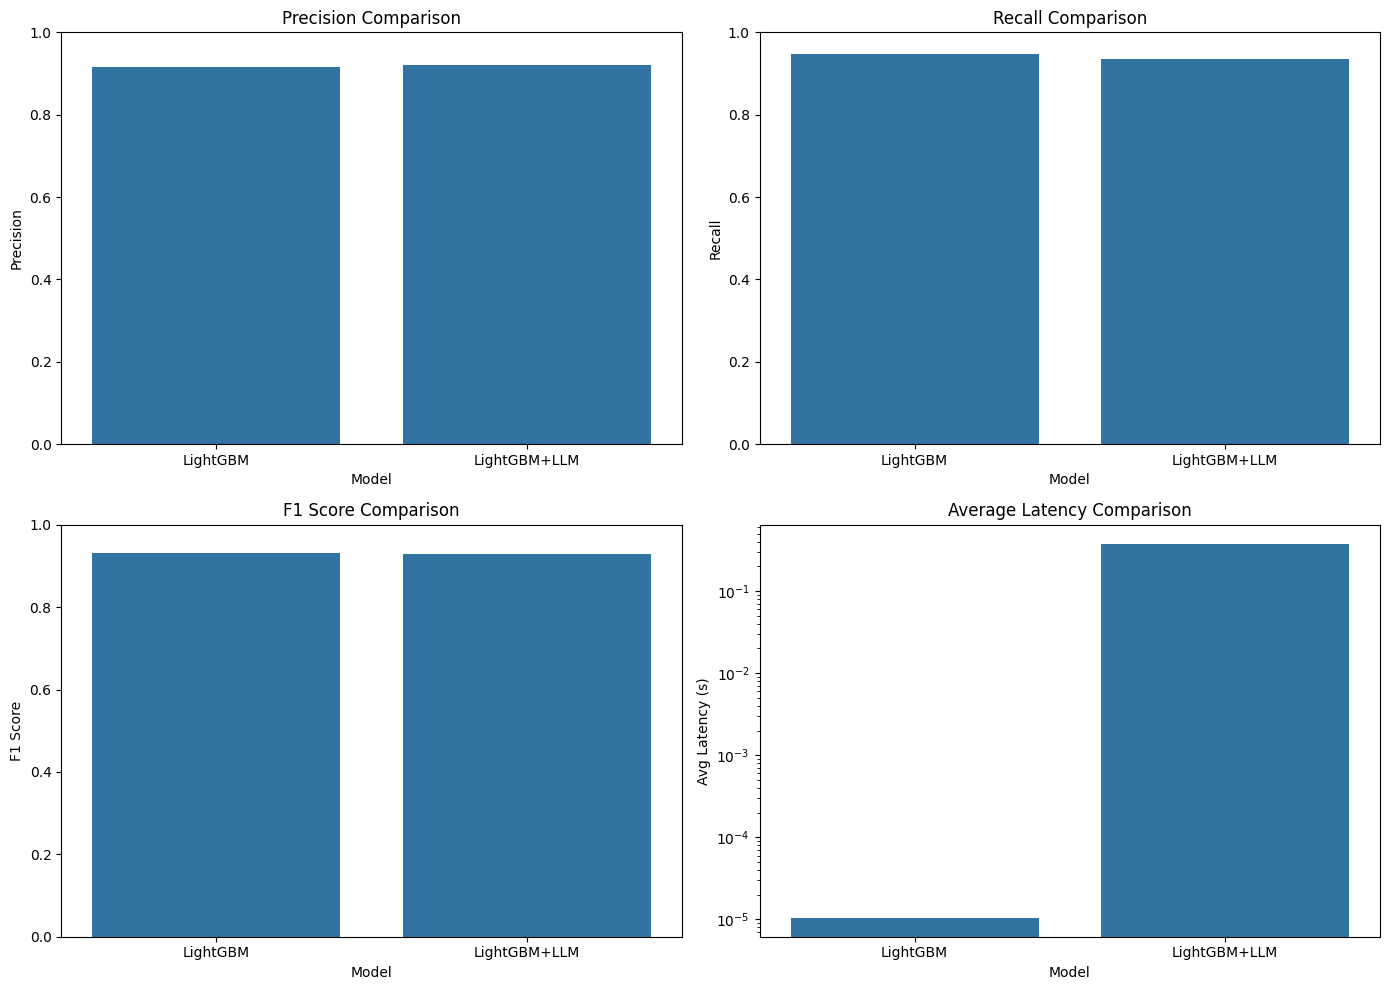

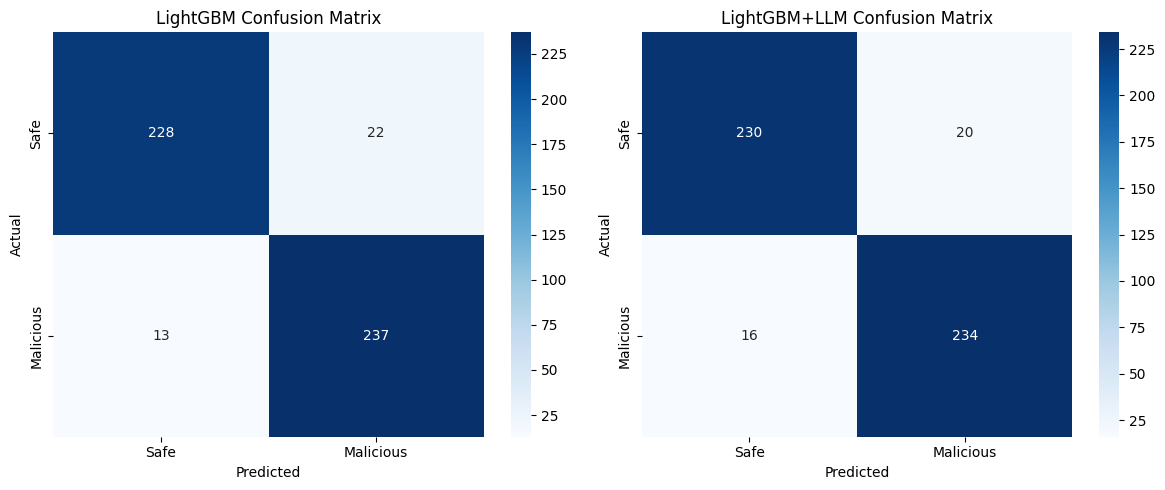

In [413]:
visualize_results(metrics_df, results)